In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from wrangle import wrangle_zillow
from wrangle import scale_zillow
from splitter import splitter

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = wrangle_zillow()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2128577 entries, 4 to 2152862
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   bedroomcnt   int64  
 1   bathroomcnt  float64
 2   sqft         int64  
 3   value        int64  
 4   yearbuilt    int64  
 5   taxamount    float64
 6   fips_name    object 
dtypes: float64(2), int64(4), object(1)
memory usage: 129.9+ MB


In [3]:
train_unscaled, validate_unscaled, test_unscaled = splitter(df)

Train = 1192002 rows (56.0%) | Validate = 510859 rows (24.0%) | Test = 425716 rows (20.0%)
You did not stratify.  If looking to stratify, ensure to add argument: "target = variable to stratify on".


In [ ]:
scaler = MinMaxScaler()
scaler.fit(train_unscaled.drop(columns=['fips_name','value']))

In [ ]:
df_train_scaled = pd.DataFrame(scaler.transform(train_unscaled.drop(columns=['fips_name','value'])),columns=train_unscaled.drop(columns=['fips_name','value']).columns.values).set_index([train_unscaled.index.values])

In [ ]:
df_train_scaled

In [5]:
train, validate, test = scale_zillow(train_unscaled, validate_unscaled, test_unscaled)
train.head(2)

,bedroomcnt,bathroomcnt,sqft,yearbuilt,taxamount,fips_name,value,fips_name_Los Angeles,fips_name_Orange,fips_name_Ventura
496600,0.333333,0.357143,0.247811,0.679070,0.028146,Los Angeles,551778,1,0,0
515181,0.333333,0.214286,0.166076,0.837209,0.018208,Orange,364588,0,1,0


##### TODO: Make a function to create the train, test, validate X and y variables, where the parameters are (train, validate, test, target)

In [6]:
X_train = train.drop(columns=['value','fips_name'])
y_train = train.value

X_validate = validate.drop(columns=['value','fips_name'])
y_validate = validate.value

X_test = test.drop(columns=['value','fips_name'])
y_test = test.value

In [9]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict value_pred_mean
value_pred_mean = y_train['value'].mean()
y_train['value_pred_mean'] = value_pred_mean
y_validate['value_pred_mean'] = value_pred_mean

# 2. compute value_pred_median
value_pred_median = y_train['value'].median()
y_train['value_pred_median'] = value_pred_median
y_validate['value_pred_median'] = value_pred_median

# 3. RMSE of value_pred_mean
rmse_train = mean_squared_error(y_train.value, y_train.value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.value, y_validate.value_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of value_pred_median
rmse_train = mean_squared_error(y_train.value, y_train.value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.value, y_validate.value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  543112.78 
Validate/Out-of-Sample:  536619.07
RMSE using Median
Train/In-Sample:  556565.1 
Validate/Out-of-Sample:  550034.92


In [13]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.value)

# predict train
y_train['value_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.value, y_train.value_pred_lm)**(1/2)

# predict validate
y_validate['value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.value, y_validate.value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  76135.80213257804 
Validation/Out-of-Sample:  76039.71785317684


In [20]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.value)

# predict train
y_train['value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.value, y_train.value_pred_lars)**(1/2)

# predict validate
y_validate['value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.value, y_validate.value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  76216.48070454314 
Validation/Out-of-Sample:  76099.87248873271


In [15]:
# create the model object
glm = TweedieRegressor(power=2, alpha=4)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.value)

# predict train
y_train['value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.value, y_train.value_pred_glm)**(1/2)

# predict validate
y_validate['value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.value, y_validate.value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  541474.8320266901 
Validation/Out-of-Sample:  534972.2075868654


<AxesSubplot:>

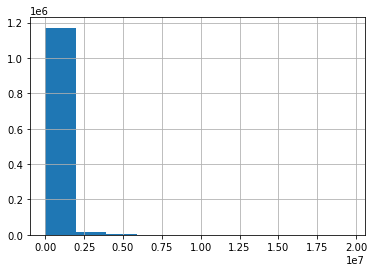

In [16]:
y_train.value.hist()

In [11]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [12]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.value)

# predict train
y_train['value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.value, y_train.value_pred_lm2)**(1/2)

# predict validate
y_validate['value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.value, y_validate.value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  73525.90246335014 
Validation/Out-of-Sample:  73830.92462845668


In [23]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['value_pred_lm'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.value, y_test.value_pred_lm)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  73680.2192208104
